# Examples for Voigt profiles (v1.2)

In [1]:
%matplotlib inline

In [2]:
### import
import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.analysis import voigt as lav
# plots
from matplotlib import pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 6.0)
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [3]:
# Define a plotting function
def plt_line(spec):
    plt.clf()
    plt.figure(dpi=1200)
    plt.plot(spec.dispersion.value, spec.flux.value, 'k-', drawstyle='steps-mid', lw=1.5)
    plt.xlim(3644., 3650.)
    plt.ylabel('Normalized Flux', fontsize=20.)
    plt.xlabel('Wavelength', fontsize=20.)
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MultipleLocator(2.))
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    plt.ylim(0., 1.1)
    plt.show()
    plt.close()

## Generate a Ly$\alpha$ line

In [4]:
abslin = AbsLine(1215.670*u.AA)

## Fill attributes

In [5]:
abslin.attrib['N'] = 10**14./u.cm**2  # log N
abslin.attrib['b'] = 25.*u.km/u.s
abslin.attrib['z'] = 2.0

## Generate Voigt profile

### Use wavelength from spectrum

In [6]:
#Load
abslin.analy['spec'] = lsio.readspec('../../linetools/spectra/tests/files/UM184_nF.fits')

In [7]:
#Generate
vmodel = abslin.generate_voigt()

/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:181: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:182: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')
/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:235: UserWarning: Assuming infinite spectral resolution, i.e. no smoothing.
  warnings.warn('Assuming infinite spectral resolution, i.e. no smoothing.')
/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:236: UserWarning: Set fwhm to smooth.
  warnings.warn('Set fwhm to smooth.')


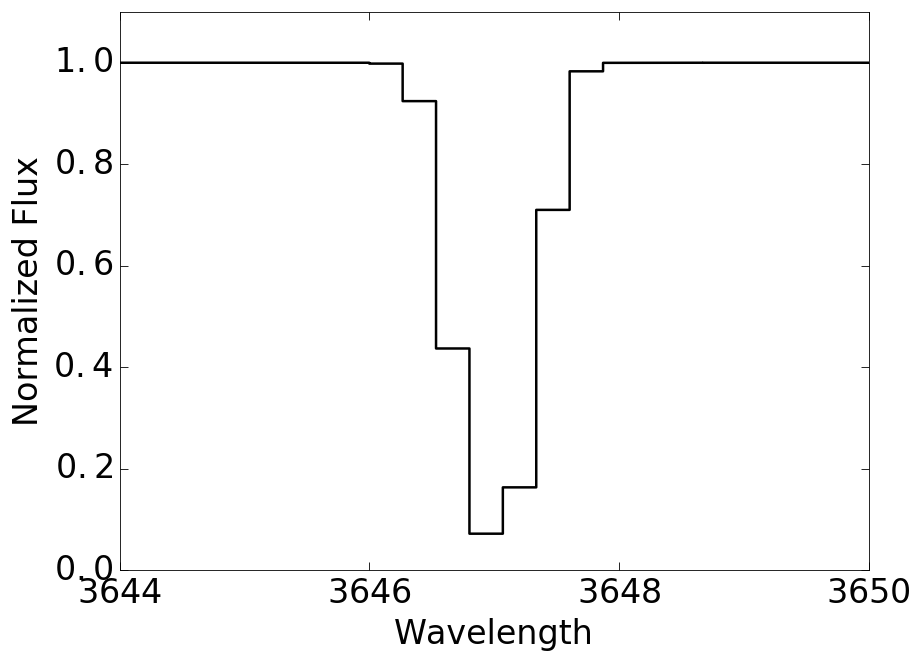

In [8]:
# Plot
plt_line(vmodel)

### Use self-generated wavelength

In [9]:
abslin.attrib['N'] = 10**17.5/u.cm**2
abslin.attrib['b'] = 20.*u.km/u.s

In [10]:
wave = np.linspace(3644, 3650,100)*u.AA

In [11]:
vmodel2 = abslin.generate_voigt(wave=wave)

/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:181: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:182: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')
/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:235: UserWarning: Assuming infinite spectral resolution, i.e. no smoothing.
  warnings.warn('Assuming infinite spectral resolution, i.e. no smoothing.')
/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:236: UserWarning: Set fwhm to smooth.
  warnings.warn('Set fwhm to smooth.')


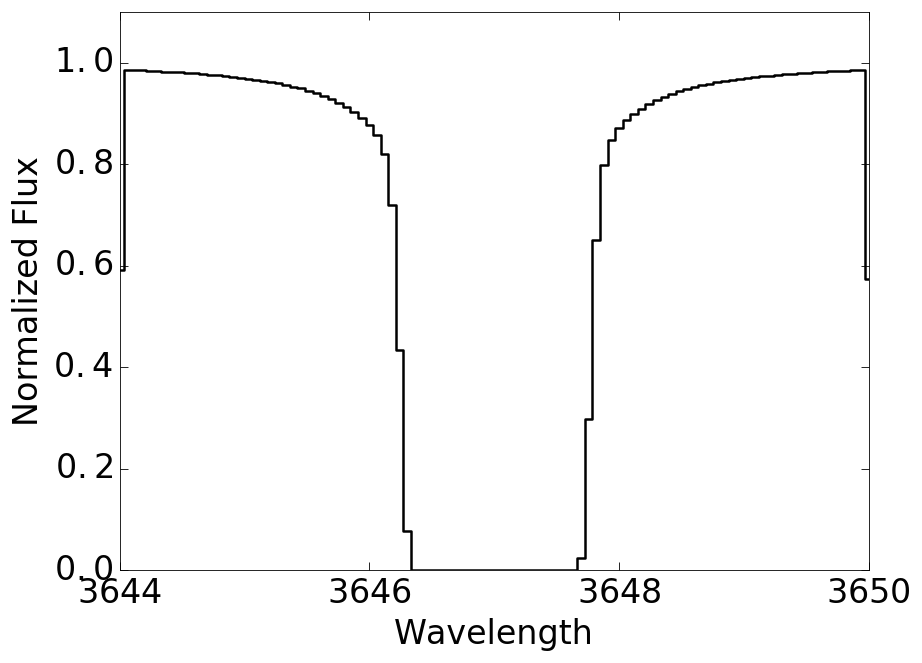

In [12]:
plt_line(vmodel2)

## Multiple Lines

In [13]:
abslin2 = AbsLine('DI 1215')
abslin2.attrib['N'] = 10**13./u.cm**2  # log N
abslin2.attrib['b'] = 15.*u.km/u.s
abslin2.attrib['z'] = 2.0

In [14]:
vmodel3 = lav.voigt_from_abslines(wave,[abslin,abslin2])

/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:181: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:182: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')
/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:235: UserWarning: Assuming infinite spectral resolution, i.e. no smoothing.
  warnings.warn('Assuming infinite spectral resolution, i.e. no smoothing.')
/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:236: UserWarning: Set fwhm to smooth.
  warnings.warn('Set fwhm to smooth.')


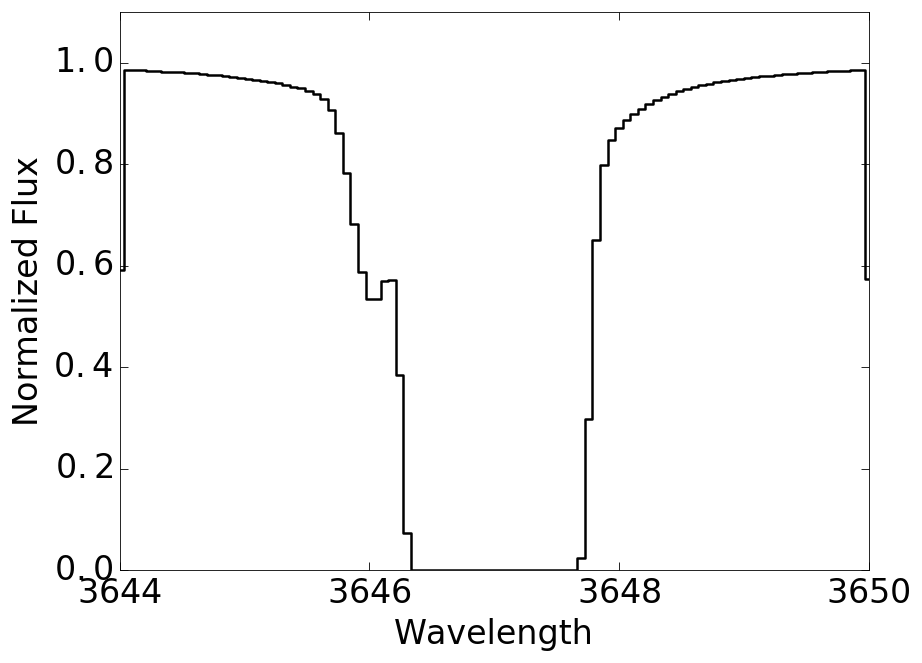

In [15]:
plt_line(vmodel3)

## $\tau$ Profiles

In [17]:
tau = lav.voigt_from_abslines(wave,abslin,ret='tau')

/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:181: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:182: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')
/Users/ncrighton/Code/Repo/linetools/build/lib.macosx-10.5-x86_64-3.4/linetools/analysis/voigt.py:220: UserWarning: Rebinned tau back to your input array.  Reconsider input
  warnings.warn('Rebinned tau back to your input array.  Reconsider input')


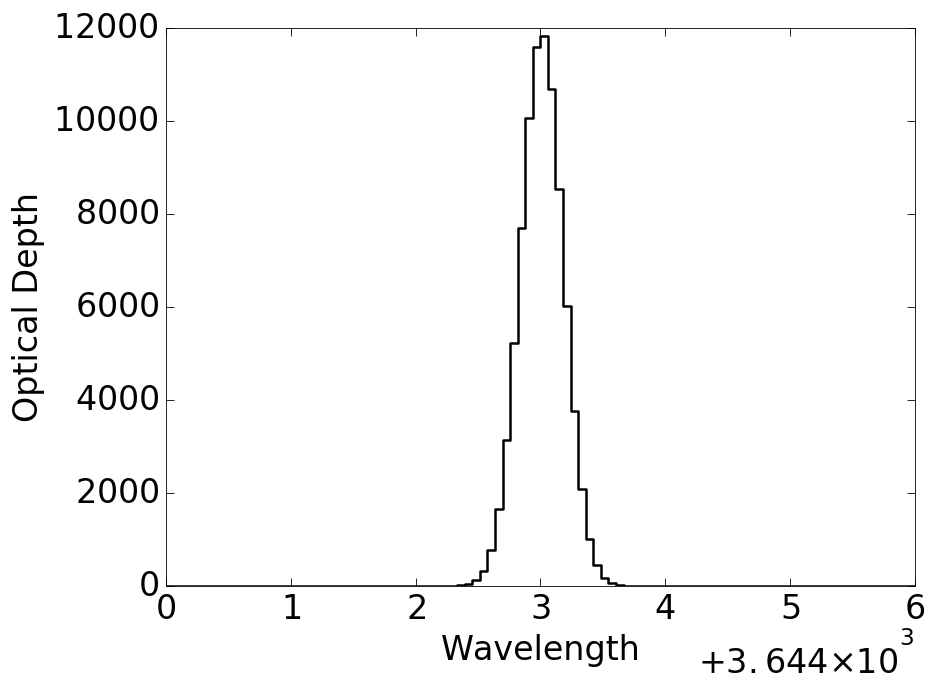

In [18]:
#
plt.clf()
plt.figure(dpi=1200)
plt.plot(wave,tau, 'k-', drawstyle='steps-mid', lw=1.5)
plt.xlim(3644., 3650.)
plt.ylabel('Optical Depth', fontsize=20.)
plt.xlabel('Wavelength', fontsize=20.)
plt.show()
plt.close()

## Fit the Voigt

In [19]:
from astropy.modeling import fitting

In [21]:
fitvoigt = lav.single_voigt_model(logN=np.log10(abslin.attrib['N'].value),b=abslin.attrib['b'].value,
                                z=abslin.attrib['z'], wrest=abslin.wrest.value, 
                                gamma=abslin.data['gamma'].value, f=abslin.data['f'],
                                 fwhm=3.)

In [22]:
fitter = fitting.LevMarLSQFitter()

In [23]:
p = fitter(fitvoigt,wave.value,vmodel2.flux.value,weights=1./(np.ones(len(wave))*0.1))
print(p)

Model: single_voigt_model
Inputs: ('wave',)
Outputs: ('flux',)
Model set size: 1
Parameters:
         logN           b            z        wrest    f       gamma    fwhm
    ------------- ------------- ------------ ------- ------ ----------- ----
    17.4929562589 20.0104211026 1.9999973925 1215.67 0.4164 626500000.0  3.0


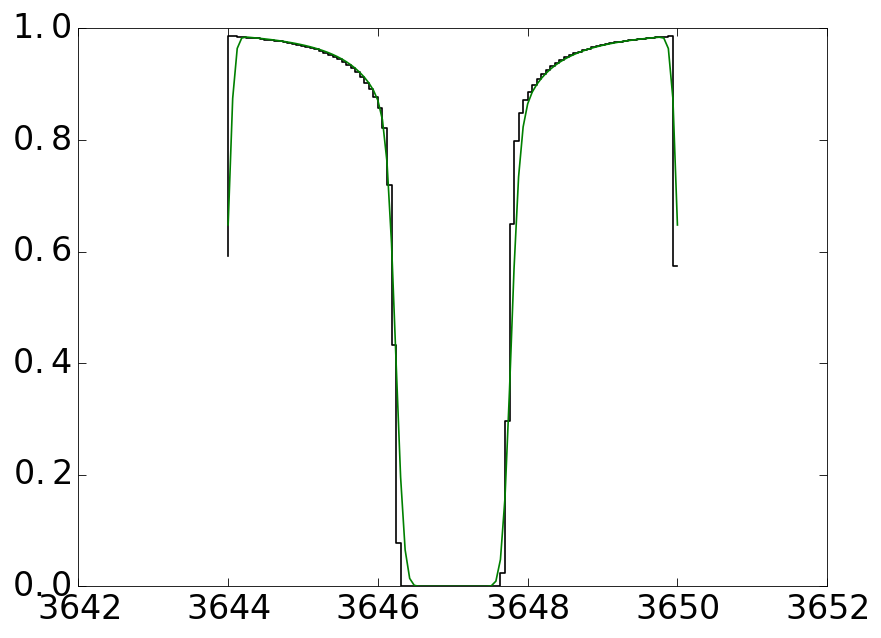

In [25]:
#
plt.clf()
plt.plot(wave, vmodel2.flux, 'k-',drawstyle='steps')
plt.plot(wave,p(wave.value), 'g-')
#xdb.xplot(wave,model.flux,p(wave.value))
plt.show()
plt.close()
# note the bad pixels at either end of the spectrum - this is a bug! It can't be 
# worked around for now by making sure that the spectrum is much larger than the region
# of interest, and discarding the first and last ~10 pixels.

## Test Voigt Models for Speed and Accuracy

In [26]:
import timeit

### Benchmark for accuracy

In [27]:
def voigt_slow(a, u):
    """ Calculate the voigt function to very high accuracy.
    Uses numerical integration, so is slow.  Answer is correct to 20
    significant figures.
    Note this needs `mpmath` or `sympy` to be installed.
    """
    try:
        import mpmath as mp
    except ImportError:
        from sympy import mpmath as mp
    with mp.workdps(20):
        z = mp.mpc(u, a)
        result = mp.exp(-z*z) * mp.erfc(-1j*z)

    return result.real

In [28]:
# This cell takes a few minutes to run.

a = 0.05
alluvoigt = np.linspace(0.,5.,1000)
true_voigt05 = []
%timeit -r 10 for uvoigt in alluvoigt: true_voigt05.append(voigt_slow(a,uvoigt))
# Just take first 1000
true_voigt05 = np.array(true_voigt05[0:1000])

1 loops, best of 10: 53.8 s per loop


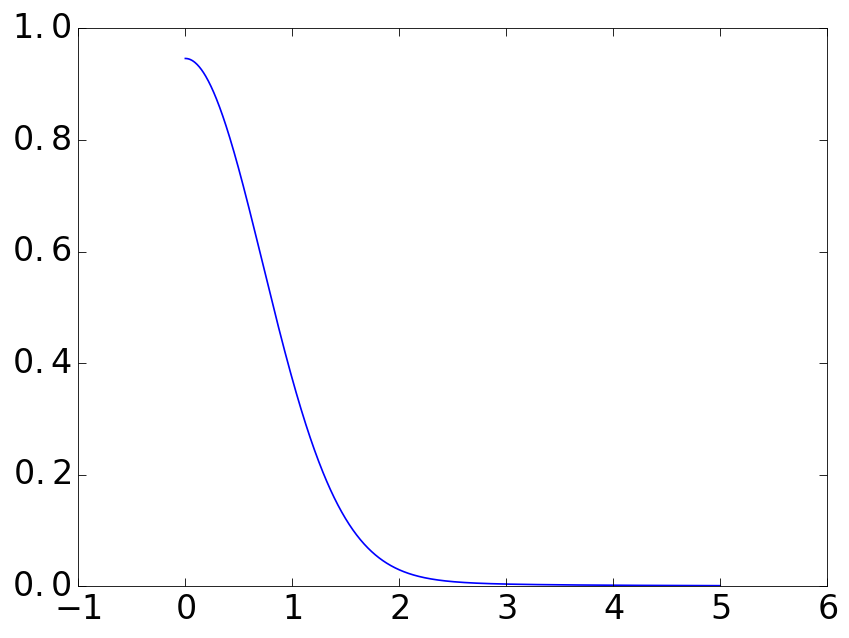

In [29]:
# Plot
plt.clf()
plt.plot(alluvoigt, true_voigt05, '-')
plt.show()
plt.close()

### VoigtKing

#### Speed

In [30]:
%timeit -r 10 king_voigt05 = lav.voigtking(alluvoigt,a)

NameError: name 'reload' is not defined

#### Accuracy

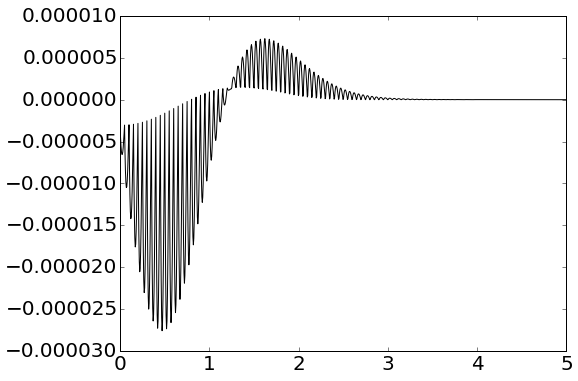

In [37]:
king_voigt05 = lav.voigtking(alluvoigt,a)
plt.clf()
plt.plot(alluvoigt, king_voigt05-true_voigt05, 'k-')
plt.show()
plt.close()

### Scipy

In [38]:
from scipy.special import wofz
def voigt_wofz(u,a):
    return wofz(u + 1j * a).real

#### Speed

In [39]:
%timeit -r 10 wofz_voigt05 = voigt_wofz(alluvoigt,a)

10000 loops, best of 10: 129 µs per loop


#### Accuracy

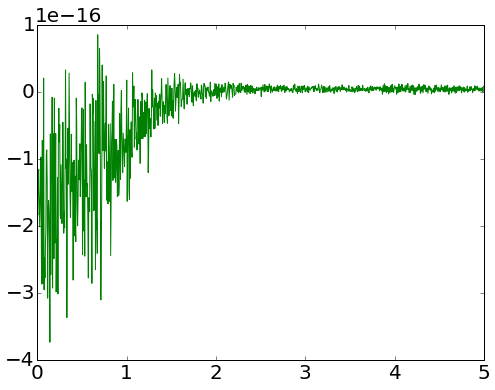

In [40]:
wofz_voigt05 = voigt_wofz(alluvoigt,a)
#
plt.clf()
plt.plot(alluvoigt, wofz_voigt05-true_voigt05, 'g-')
plt.show()
plt.close()